# Results: Correlations between Neon line Ratios and AGN fraction and others physical properties

---------------------------------------

In [1]:
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import ks_2samp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import astropy.units as u
import seaborn as sns #For graphic the histograms
import bootstrap_corr as bsc
import warnings
warnings.filterwarnings('ignore')


from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

In [2]:
path_graphs = '../Datos/Final/Graphics/'
path_FINAL = '../Datos/Final/'

Reading the data with the Ne line ratios and the results from CIGALE:

In [3]:
Ne_Sy = Table.read(path_FINAL+'final_results.fits', format='fits')
print('Total number of galaxies with Ne ratios data: ',len(Ne_Sy))

Total number of galaxies with Ne ratios data:  97


In [4]:
idx_SyG = np.where(Ne_Sy['otype']=='SyG')[0]
Ne_Sy[idx_SyG]['Main_id','otype','bayes.agn.i','bayes.agn.i_err']

Main_id,otype,bayes.agn.i,bayes.agn.i_err
bytes24,bytes3,float64,float64
ESO 602-25,SyG,30.08084083889463,1.796412623689738


In [5]:
#Ne_Sy['otype'][idx_SyG] = 'Sy1'
#Ne_Sy['otype'][idx_SyG] = 'Sy2'

#Ne_Sy[idx_SyG]['Main_id','otype','bayes.agn.i','bayes.agn.i_err']

In [6]:
Ne_Sy[0:5]

Main_id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err,CountPoints,RA,DEC,otype,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,CIGALE_setup,NED_Ne_IR_info,log_[NeV]*,log_[NeII]*,log_[NeV]$^+$,log_[NeIII]$^+$,log_[NeIII]$^-$,log_[NeII]$^-$,log_[NeV]_err*,log_[NeII]_err*,log_[NeV]_err$^+$,log_[NeIII]_err$^+$,log_[NeIII]_err$^-$,log_[NeII]_err$^-$,log_[NeV]/[NeII],log_[NeV]/[NeII]_err,log_[NeV]/[NeIII],log_[NeV]/[NeIII]_err,log_[NeIII]/[NeII],log_[NeIII]/[NeII]_err,log_bayes.sfh.sfr,log_bayes.sfh.sfr_err,log_bayes.stellar.m_star,log_bayes.stellar.m_star_err,log_bayes.agn.disk_luminosity,log_bayes.agn.disk_luminosity_err,log_bayes.agn.luminosity,log_bayes.agn.luminosity_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solLum,solLum,solLum,solLum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solLum,solLum,solLum,solLum
bytes24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes3,bytes50,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2C 94,0.059615,0.041200000850949436,0.008909546,0.05980000059935264,0.008132035999999999,--,--,1.0999999940395355,0.05,2.3799999617040157,0.09000000000000001,3.7899999879300594,0.16,--,--,3.978181799704378,0.6708949,5.1745456347072665,0.8724677000000001,4.741000244393945,1.0060815,5.957499959130179,0.35744999754781076,5.77,0.17309999999999998,9.045000000000002,0.27135000000000004,7.723522715602409,0.46341136293614454,13.100000000000001,0.393,22.95,0.6885,--,--,36.10624933317304,2.166374959990382,109.35000100955367,6.561000060573219,100.04999905824661,4.001999962329864,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,17.0,17.220292429510003,13.33729522217,Sy2,*|AGN|G|Rad|Sy2|X,2000000000.0,300000000.0,3900000000.0,200000000.0,0.5128205128205128,0.0812943431354469,2000000000.0,300000000.0,5300000000.0,200000000.0,0.37735849056603776,0.05836748377170459,5300000000.0,200000000.0,3900000000.0,200000000.0,1.358974358974359,0.08652562196640158,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,360178641.6940187,133777936.61431195,6

## Preparing the data:

### Separating the sample according the Ne ratio info

In [7]:
NeVNeII_Sy = Table(Ne_Sy)
NeVNeII_Sy.remove_rows(np.where(np.isnan(NeVNeII_Sy[r'[NeV]/[NeII]*']))[0])
NeVNeIII_Sy = Table(Ne_Sy)
NeVNeIII_Sy.remove_rows(np.where(np.isnan(NeVNeIII_Sy[r'[NeV]/[NeIII]$^+$']))[0])
NeIIINeII_Sy = Table(Ne_Sy)
NeIIINeII_Sy.remove_rows(np.where(np.isnan(NeIIINeII_Sy[r'[NeIII]/[NeII]$^-$']))[0])

### Separating the groups in Sy1 and Sy2  (according their classification in SIMBAD)

In [8]:
Ne_Sy1 = Ne_Sy[Ne_Sy['otype']=='Sy1']
Ne_Sy2 = Ne_Sy[Ne_Sy['otype']=='Sy2']
Ne_SyG = Ne_Sy[Ne_Sy['otype']=='SyG']

NeVNeII_Sy1 = NeVNeII_Sy[NeVNeII_Sy['otype']=='Sy1']
NeVNeII_Sy2 = NeVNeII_Sy[NeVNeII_Sy['otype']=='Sy2']
NeVNeII_SyG = NeVNeII_Sy[NeVNeII_Sy['otype']=='SyG']

NeVNeIII_Sy1 = NeVNeIII_Sy[NeVNeIII_Sy['otype']=='Sy1']
NeVNeIII_Sy2 = NeVNeIII_Sy[NeVNeIII_Sy['otype']=='Sy2']
NeVNeIII_SyG = NeVNeIII_Sy[NeVNeIII_Sy['otype']=='SyG']

NeIIINeII_Sy1 = NeIIINeII_Sy[NeIIINeII_Sy['otype']=='Sy1']
NeIIINeII_Sy2 = NeIIINeII_Sy[NeIIINeII_Sy['otype']=='Sy2']
NeIIINeII_SyG = NeIIINeII_Sy[NeIIINeII_Sy['otype']=='SyG']

### Converting tables to pandas to compute the correlations coeficients

For computing the pearson's correlation coeficiens, we will use the function corr from Pandas, so we need to convert the tables to pandas

In [9]:
df_Ne_Sy = Ne_Sy.to_pandas()
df_Ne_Sy1 = Ne_Sy1.to_pandas()
df_Ne_Sy2 = Ne_Sy2.to_pandas()
df_Ne_SyG = Ne_SyG.to_pandas()
df_NeVNeII_Sy = NeVNeII_Sy.to_pandas()
df_NeVNeII_Sy1 = NeVNeII_Sy1.to_pandas()
df_NeVNeII_Sy2 = NeVNeII_Sy2.to_pandas()
df_NeVNeII_SyG = NeVNeII_SyG.to_pandas()
df_NeVNeIII_Sy = NeVNeIII_Sy.to_pandas()
df_NeVNeIII_Sy1 = NeVNeIII_Sy1.to_pandas()
df_NeVNeIII_Sy2 = NeVNeIII_Sy2.to_pandas()
df_NeVNeIII_SyG = NeVNeIII_SyG.to_pandas()
df_NeIIINeII_Sy = NeIIINeII_Sy.to_pandas()
df_NeIIINeII_Sy1 = NeIIINeII_Sy1.to_pandas()
df_NeIIINeII_Sy2 = NeIIINeII_Sy2.to_pandas()
df_NeIIINeII_SyG = NeIIINeII_SyG.to_pandas()

### Bootstraping function for the correlation coefficients

With the function bootstrapCorr in bootstrap_corr.py (imported as bsc at the begining of this notebook) we compute the correlation coefficient with bootstrapping

-------------------------
### Bins for histograms

The next functions are just to determinate the number of bins for histograms. Maybe this will not be used in all cases because some data have "outliers"

In [10]:
def sturges(data):
    num_data = len(data)
    num_bins = int(np.log2(num_data)) + 1
    return num_bins


def freedman_diaconis(data):
    num_data = len(data)
    irq = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * irq / np.power(num_data, 1/3)
    num_bins = int((np.max(data) -  np.min(data)) / bin_width)  + 1
    return num_bins

----------------------------------------

# [NeV]/[NeII]

In [11]:
print('From the', len(NeVNeII_Sy),'galaxies with [NeV]/[NeII] info:')
print(len(NeVNeII_Sy1),'galaxies are Seyfert 1,')
print(len(NeVNeII_Sy2),'galaxies are Seyfert 2,')
print(len(NeVNeII_SyG),'galaxies are Seyfert without classification.')

From the 84 galaxies with [NeV]/[NeII] info:
43 galaxies are Seyfert 1,
40 galaxies are Seyfert 2,
1 galaxies are Seyfert without classification.


## [NeV]/[NeII] vs AGN Fraction

### Correlation Coefficients:

In [12]:
NeVNeII_corr_fracAGN_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['bayes.agn.fracAGN'])
NeVNeII_corr_fracAGN_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['bayes.agn.fracAGN'])
NeVNeII_corr_fracAGN_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:')
print('Total Sample: ',NeVNeII_corr_fracAGN_Sy)
print('Seyfert 1: ',NeVNeII_corr_fracAGN_Sy1)
print('Seyfert 2: ',NeVNeII_corr_fracAGN_Sy2)

Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:
Total Sample:  0.542591084194734
Seyfert 1:  0.6576374537135323
Seyfert 2:  0.2775528428230336


In [13]:
NeVNeII_fracAGN_Sy = bsc.bootstrapCorr(10000,0.8,df_NeVNeII_Sy,'log_[NeV]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeVNeII_fracAGN_Sy[0]),'max:',max(NeVNeII_fracAGN_Sy[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 67 of 84
Number of samples: 10000
Median: 0.5439912947843738
Mean: 0.5360485515221973
Variance: 0.008914017929030986
Standard Desviation: 0.09441407696435414
90 % confidence interval: 0.37023533279860665 - 0.6788795701510663
min: 0.06715935026504176 max: 0.7981414624960679


In [14]:
NeVNeII_fracAGN_Sy1 = bsc.bootstrapCorr(10000,0.8,df_NeVNeII_Sy1,'log_[NeV]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeVNeII_fracAGN_Sy1[0]),'max:',max(NeVNeII_fracAGN_Sy1[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 34 of 43
Number of samples: 10000
Median: 0.6570748451490072
Mean: 0.6412080833161525
Variance: 0.012838379120668183
Standard Desviation: 0.11330657139225501
90 % confidence interval: 0.42982560356885824 - 0.7967050257256656
min: 0.035084556733478496 max: 0.9183009315375802


In [15]:
NeVNeII_fracAGN_Sy2 = bsc.bootstrapCorr(10000,0.8,df_NeVNeII_Sy2,'log_[NeV]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeVNeII_fracAGN_Sy2[0]),'max:',max(NeVNeII_fracAGN_Sy2[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 32 of 40
Number of samples: 10000
Median: 0.2839775731890093
Mean: 0.2788320762452205
Variance: 0.021400146651701545
Standard Desviation: 0.14628788962761594
90 % confidence interval: 0.03137308815303474 - 0.5155222510988939
min: -0.2891922996431448 max: 0.7557098175870782


### Lineal Regressions

In [16]:
lr_model = LinearRegression()

X_Sy = df_NeVNeII_Sy[['log_[NeV]/[NeII]']]
y_Sy = df_NeVNeII_Sy['bayes.agn.fracAGN']

X_Sy1 = df_NeVNeII_Sy1[['log_[NeV]/[NeII]']]
y_Sy1 = df_NeVNeII_Sy1['bayes.agn.fracAGN']

X_Sy2 = df_NeVNeII_Sy2[['log_[NeV]/[NeII]']]
y_Sy2 = df_NeVNeII_Sy2['bayes.agn.fracAGN']

NeVNeIIrange = np.linspace(min(NeVNeII_Sy['log_[NeV]/[NeII]']),max(NeVNeII_Sy['log_[NeV]/[NeII]']),len(NeVNeII_Sy['log_[NeV]/[NeII]']))

-----------------
Some common parameters for the graphics of the Neon Line Ratios vs $f_{AGN}$:

In [17]:
#Labels text and fontsize for the graphics of Ne Ratios vs fAGN:
xr_label = r'Pearson correlation coefficient (PCC)'
yl_label = r'$f_{AGN}$'
yr_label = r'Density'
fontsize_labels = 14

#Aggregate statistic to compute in each bin in the histograms
#Options: count, frequency, probability, percent and density
stat = 'density'

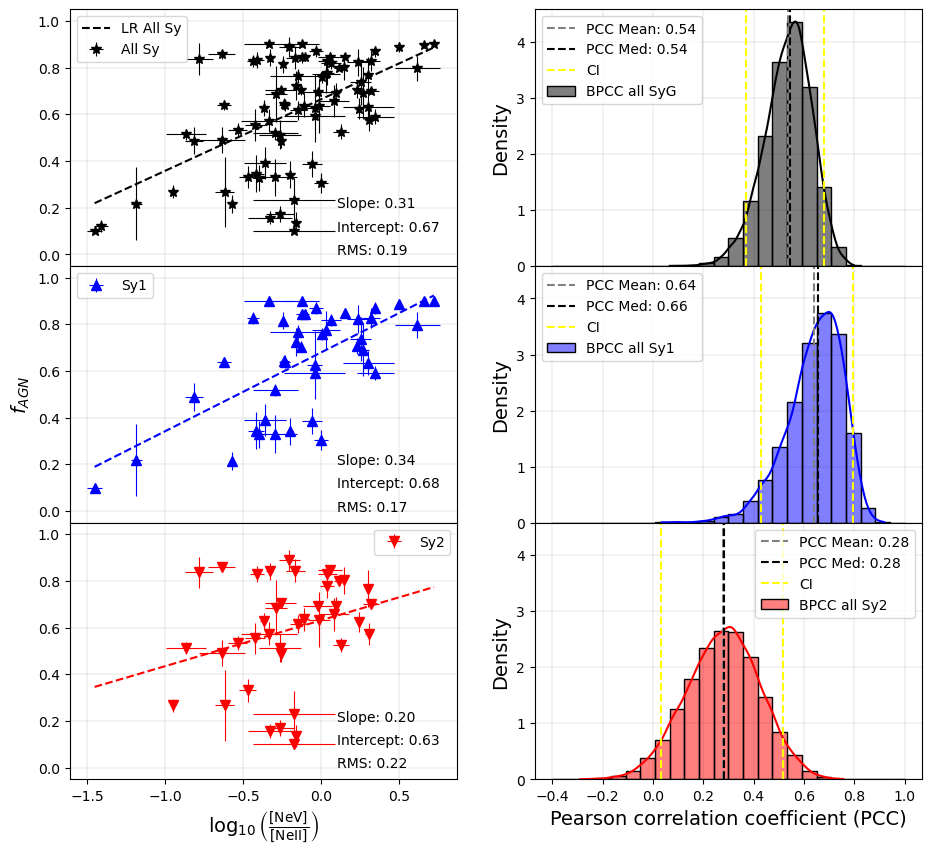

In [75]:
plt.figure(figsize=(11,10))

#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)
NeVNeII_lr_Sy = lr_model.fit(X_Sy, y_Sy)
y_Sy_pred = lr_model.predict(X_Sy)
NeVNeII_Sy_rmse = mean_squared_error(y_Sy,y_Sy_pred,squared=False)
lr_Sy = NeVNeII_lr_Sy.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy.intercept_
ax1 = plt.subplot(321)
ax1.errorbar(NeVNeII_Sy['log_[NeV]/[NeII]'], NeVNeII_Sy['bayes.agn.fracAGN'],NeVNeII_Sy['bayes.agn.fracAGN_err'], NeVNeII_Sy['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All Sy')
ax1.plot(NeVNeIIrange,lr_Sy,'--k',label='LR All Sy')
#ax1.plot(NeVNeIIrange,lr_Sy1,'--b',label='LR Sy1')
#ax1.plot(NeVNeIIrange,lr_Sy2,'--r',label='LR Sy2')
#ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.text(0.1,0.2,'Slope: %.2f' %NeVNeII_lr_Sy.coef_[0],fontsize=10)
ax1.text(0.1,0.1,'Intercept: %.2f' %NeVNeII_lr_Sy.intercept_,fontsize=10)
ax1.text(0.1,0.0,'RMS: %.2f' %NeVNeII_Sy_rmse,fontsize=10)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.1)

NeVNeII_lr_Sy1 = lr_model.fit(X_Sy1, y_Sy1)
y_Sy1_pred = lr_model.predict(X_Sy1)
NeVNeII_Sy1_rmse = mean_squared_error(y_Sy1,y_Sy1_pred,squared=False)
lr_Sy1 = NeVNeII_lr_Sy1.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy1.intercept_
ax2 = plt.subplot(323,sharex=ax1,sharey=ax1)
ax2.errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['bayes.agn.fracAGN'],NeVNeII_Sy1['bayes.agn.fracAGN_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.plot(NeVNeIIrange,lr_Sy1,'--b')
ax2.set_ylabel(yl_label, fontsize=fontsize_labels)
ax2.text(0.1,0.2,'Slope: %.2f' %NeVNeII_lr_Sy1.coef_[0],fontsize=10)
ax2.text(0.1,0.1,'Intercept: %.2f' %NeVNeII_lr_Sy1.intercept_,fontsize=10)
ax2.text(0.1,0.0,'RMS: %.2f' %NeVNeII_Sy1_rmse,fontsize=10)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.1)

NeVNeII_lr_Sy2 = lr_model.fit(X_Sy2, y_Sy2)
y_Sy2_pred = lr_model.predict(X_Sy2)
NeVNeII_Sy2_rmse = mean_squared_error(y_Sy2,y_Sy2_pred,squared=False)
lr_Sy2 = NeVNeII_lr_Sy2.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy2.intercept_
ax3 = plt.subplot(325,sharex=ax1,sharey=ax1)
ax3.errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['bayes.agn.fracAGN'],NeVNeII_Sy2['bayes.agn.fracAGN_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.plot(NeVNeIIrange,lr_Sy2,'--r')
ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
#ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.text(0.1,0.2,'Slope: %.2f' %NeVNeII_lr_Sy2.coef_[0],fontsize=10)
ax3.text(0.1,0.1,'Intercept: %.2f' %NeVNeII_lr_Sy2.intercept_,fontsize=10)
ax3.text(0.1,0.0,'RMS: %.2f' %NeVNeII_Sy2_rmse,fontsize=10)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.1)

bins = np.linspace(-0.4,1.0,25)
binsSy = sturges(NeVNeII_fracAGN_Sy[0])
binsSy1 = sturges(NeVNeII_fracAGN_Sy1[0])
binsSy2 = sturges(NeVNeII_fracAGN_Sy2[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(322)
sns.histplot(NeVNeII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeVNeII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy[1])
ax4.axvline(x=NeVNeII_fracAGN_Sy[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy[3])
ax4.axvline(x=NeVNeII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeVNeII_fracAGN_Sy[5],ls='--',color='yellow')
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(324,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC all Sy1')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy1[1])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy1[3])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_ylabel(yr_label,fontsize=fontsize_labels)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(326,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC all Sy2')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy2[1])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy2[3])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[5],ls='--',color='yellow')
ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set_ylabel(yr_label,fontsize=fontsize_labels)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.0,wspace=0.2) #Space between subplots
plt.savefig(path_graphs+'NeV_NeII_vs_fracAGN_Sy1_vs_Sy2.jpg')

Same graphic above, but in horizontal plot:

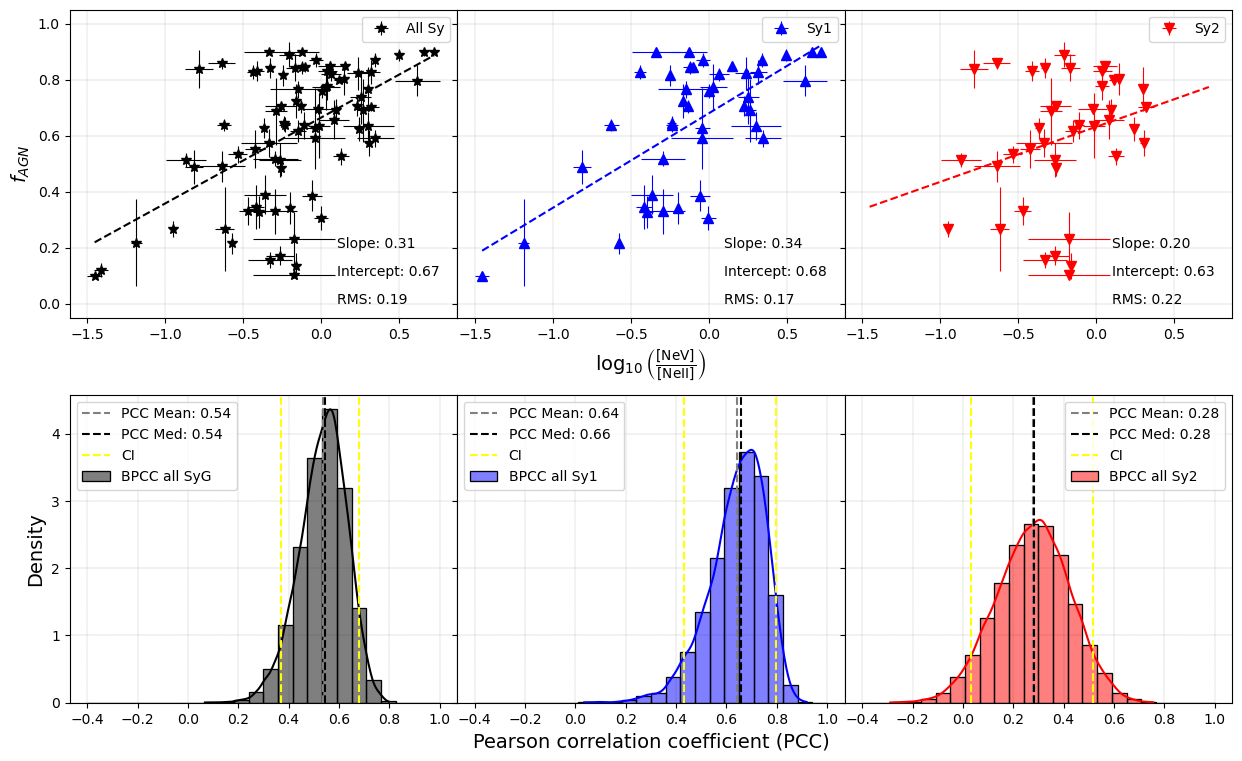

In [72]:
plt.figure(figsize=(15,9))

#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)
NeVNeII_lr_Sy = lr_model.fit(X_Sy, y_Sy)
y_Sy_pred = lr_model.predict(X_Sy)
NeVNeII_Sy_rmse = mean_squared_error(y_Sy,y_Sy_pred,squared=False)
lr_Sy = NeVNeII_lr_Sy.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy.intercept_
ax1 = plt.subplot(231)
ax1.errorbar(NeVNeII_Sy['log_[NeV]/[NeII]'], NeVNeII_Sy['bayes.agn.fracAGN'],NeVNeII_Sy['bayes.agn.fracAGN_err'], NeVNeII_Sy['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All Sy')
ax1.plot(NeVNeIIrange,lr_Sy,'--k')
#ax1.plot(NeVNeIIrange,lr_Sy1,'--b',label='LR Sy1')
#ax1.plot(NeVNeIIrange,lr_Sy2,'--r',label='LR Sy2')
#ax1.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.text(0.1,0.2,'Slope: %.2f' %NeVNeII_lr_Sy.coef_[0],fontsize=10)
ax1.text(0.1,0.1,'Intercept: %.2f' %NeVNeII_lr_Sy.intercept_,fontsize=10)
ax1.text(0.1,0.0,'RMS: %.2f' %NeVNeII_Sy_rmse,fontsize=10)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.1)

NeVNeII_lr_Sy1 = lr_model.fit(X_Sy1, y_Sy1)
y_Sy1_pred = lr_model.predict(X_Sy1)
NeVNeII_Sy1_rmse = mean_squared_error(y_Sy1,y_Sy1_pred,squared=False)
lr_Sy1 = NeVNeII_lr_Sy1.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy1.intercept_
ax2 = plt.subplot(232,sharex=ax1,sharey=ax1)
ax2.errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['bayes.agn.fracAGN'],NeVNeII_Sy1['bayes.agn.fracAGN_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.plot(NeVNeIIrange,lr_Sy1,'--b')
ax2.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax2.yaxis.set_tick_params(labelleft=False)
ax2.text(0.1,0.2,'Slope: %.2f' %NeVNeII_lr_Sy1.coef_[0],fontsize=10)
ax2.text(0.1,0.1,'Intercept: %.2f' %NeVNeII_lr_Sy1.intercept_,fontsize=10)
ax2.text(0.1,0.0,'RMS: %.2f' %NeVNeII_Sy1_rmse,fontsize=10)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.1)

NeVNeII_lr_Sy2 = lr_model.fit(X_Sy2, y_Sy2)
y_Sy2_pred = lr_model.predict(X_Sy2)
NeVNeII_Sy2_rmse = mean_squared_error(y_Sy2,y_Sy2_pred,squared=False)
lr_Sy2 = NeVNeII_lr_Sy2.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy2.intercept_
ax3 = plt.subplot(233,sharex=ax1,sharey=ax1)
ax3.errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['bayes.agn.fracAGN'],NeVNeII_Sy2['bayes.agn.fracAGN_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.plot(NeVNeIIrange,lr_Sy2,'--r')
#ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax3.yaxis.set_tick_params(labelleft=False)
ax3.text(0.1,0.2,'Slope: %.2f' %NeVNeII_lr_Sy2.coef_[0],fontsize=10)
ax3.text(0.1,0.1,'Intercept: %.2f' %NeVNeII_lr_Sy2.intercept_,fontsize=10)
ax3.text(0.1,0.0,'RMS: %.2f' %NeVNeII_Sy2_rmse,fontsize=10)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.1)

bins = np.linspace(-0.4,1.0,25)
#bins = sturges(NeVNeII_fracAGN_Sy[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(234)
sns.histplot(NeVNeII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeVNeII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy[1])
ax4.axvline(x=NeVNeII_fracAGN_Sy[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy[3])
ax4.axvline(x=NeVNeII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeVNeII_fracAGN_Sy[5],ls='--',color='yellow')
#ax4.set_xlabel(xr_label,fontsize=fontsize_labels)
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(235,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC all Sy1')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy1[1])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy1[3])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_xlabel(xr_label,fontsize=fontsize_labels)
ax5.set(ylabel=None)
ax5.yaxis.set_tick_params(labelleft=False)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(236,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC all Sy2')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy2[1])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy2[3])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[5],ls='--',color='yellow')
#ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set(ylabel=None)
ax6.yaxis.set_tick_params(labelleft=False)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.25,wspace=0.0) #Space between subplots

## [NeV]/[NeII] vs other parameters (from CIGALE)

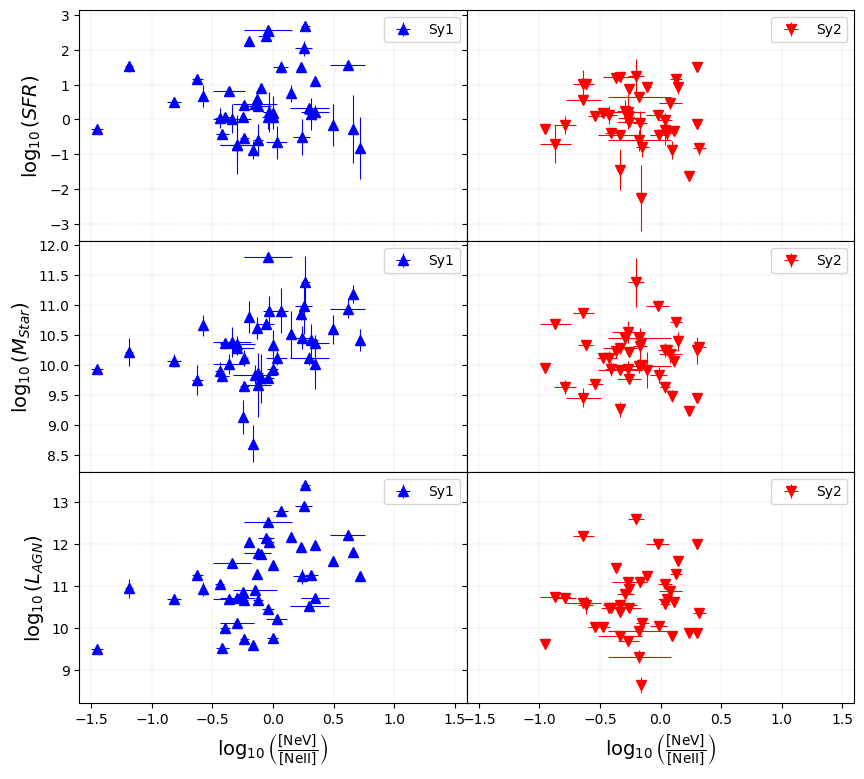

In [20]:
fig, axs = plt.subplots(3,2,figsize=(10,9),sharex='col',sharey='row')
#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)

axs[0,0].errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['log_bayes.sfh.sfr'],
                  NeVNeII_Sy1['log_bayes.sfh.sfr_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
axs[0,0].set_ylabel(r'$\log_{10}(SFR)$', fontsize=14)
axs[0,0].set_xlim(-1.6,1.6)
axs[0,0].legend()
axs[0,0].grid(color='k', linestyle='--', linewidth=0.05)

axs[0,1].errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['log_bayes.sfh.sfr'],
                  NeVNeII_Sy2['log_bayes.sfh.sfr_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
axs[0,1].set_xlim(-1.6,1.6)
axs[0,1].legend()
axs[0,1].grid(color='k', linestyle='--', linewidth=0.05)

axs[1,0].errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['log_bayes.stellar.m_star'],
                  NeVNeII_Sy1['log_bayes.stellar.m_star_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
axs[1,0].set_ylabel(r'$\log_{10}(M_{Star})$', fontsize=14)
axs[1,0].legend()
axs[1,0].grid(color='k', linestyle='--', linewidth=0.05)

axs[1,1].errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['log_bayes.stellar.m_star'],
                  NeVNeII_Sy2['log_bayes.stellar.m_star_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
axs[1,1].legend()
axs[1,1].grid(color='k', linestyle='--', linewidth=0.05)

axs[2,0].errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['log_bayes.agn.luminosity'],
                  NeVNeII_Sy1['log_bayes.agn.luminosity_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
axs[2,0].set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$',fontsize=14)
axs[2,0].set_ylabel(r'$\log_{10}(L_{AGN})$', fontsize=14)
axs[2,0].legend()
axs[2,0].grid(color='k', linestyle='--', linewidth=0.05)

axs[2,1].errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['log_bayes.agn.luminosity'],
                  NeVNeII_Sy2['log_bayes.agn.luminosity_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
axs[2,1].set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$',fontsize=14)
axs[2,1].legend()
axs[2,1].grid(color='k', linestyle='--', linewidth=0.05)


plt.subplots_adjust(hspace=0.0,wspace=0.0) #Space between subplots

### Correlation SFR:

In [21]:
NeVNeII_corr_SFR_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['log_bayes.sfh.sfr'])
NeVNeII_corr_SFR_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['log_bayes.sfh.sfr'])
NeVNeII_corr_SFR_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['log_bayes.sfh.sfr'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeII] ratio and Star Forming Rate:')
print('Total Sample: ',NeVNeII_corr_SFR_Sy)
print('Seyfert 1: ',NeVNeII_corr_SFR_Sy1)
print('Seyfert 2: ',NeVNeII_corr_SFR_Sy2)


Pearson's correlation coefficient between [NeV]/[NeII] ratio and Star Forming Rate:
Total Sample:  6.901719612578551e-06
Seyfert 1:  0.047603663153596446
Seyfert 2:  -0.0790016387556346


In [22]:
print('All Seyfert Galaxies:')
NeVNeII_SFR_Sy = bsc.bootstrapCorr(10000,1,df_NeVNeII_Sy,'log_[NeV]/[NeII]','log_bayes.sfh.sfr')
print('\nSeyfert 1:')
NeVNeII_SFR_Sy1 = bsc.bootstrapCorr(10000,1,df_NeVNeII_Sy1,'log_[NeV]/[NeII]','log_bayes.sfh.sfr')
print('\nSeyfert 2:')
NeVNeII_SFR_Sy2 = bsc.bootstrapCorr(10000,1,df_NeVNeII_Sy2,'log_[NeV]/[NeII]','log_bayes.sfh.sfr')

All Seyfert Galaxies:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.sfh.sfr :
Samples lenght: 84 of 84
Number of samples: 10000
Median: 0.0024222183788682804
Mean: 0.0007456452670968143
Variance: 0.011366749829857114
Standard Desviation: 0.10661496062868998
90 % confidence interval: -0.17594334477711307 - 0.17204941076054078

Seyfert 1:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.sfh.sfr :
Samples lenght: 43 of 43
Number of samples: 10000
Median: 0.05159039080120524
Mean: 0.049569075213301395
Variance: 0.020643104150655768
Standard Desviation: 0.143677082900008
90 % confidence interval: -0.1909106867865423 - 0.2818406306329687

Seyfert 2:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.sfh.sfr :
Samples lenght: 40 of 40
Number of samples: 10000
Median: -0.08338720520331577
Mean: -0.08443195269099849
Variance: 0.024680524317812046
Standard Desviation: 0.157100363

### Correlation $M_{star}$:

In [23]:
NeVNeII_corr_m_star_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['log_bayes.stellar.m_star'])
NeVNeII_corr_m_star_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['log_bayes.stellar.m_star'])
NeVNeII_corr_m_star_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['log_bayes.stellar.m_star'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeII] ratio and Star Mass:')
print('Total Sample: ',NeVNeII_corr_m_star_Sy)
print('Seyfert 1: ',NeVNeII_corr_m_star_Sy1)
print('Seyfert 2: ',NeVNeII_corr_m_star_Sy2)


Pearson's correlation coefficient between [NeV]/[NeII] ratio and Star Mass:
Total Sample:  0.23237026989629853
Seyfert 1:  0.3697001372672727
Seyfert 2:  -0.044860856135579205


In [24]:
print('All Seyfert Galaxies:')
NeVNeII_m_star_Sy = bsc.bootstrapCorr(10000,0.7,df_NeVNeII_Sy,'log_[NeV]/[NeII]','log_bayes.stellar.m_star')
print('\nSeyfert 1:')
NeVNeII_m_star_Sy1 = bsc.bootstrapCorr(10000,0.7,df_NeVNeII_Sy1,'log_[NeV]/[NeII]','log_bayes.stellar.m_star')
print('\nSeyfert 2:')
NeVNeII_m_star_Sy2 = bsc.bootstrapCorr(10000,0.7,df_NeVNeII_Sy2,'log_[NeV]/[NeII]','log_bayes.stellar.m_star')

All Seyfert Galaxies:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.stellar.m_star :
Samples lenght: 59 of 84
Number of samples: 10000
Median: 0.2362759160117246
Mean: 0.23402754072938006
Variance: 0.01079832707267362
Standard Desviation: 0.1039149992670626
90 % confidence interval: 0.06111161791576191 - 0.40340536692820755

Seyfert 1:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.stellar.m_star :
Samples lenght: 30 of 43
Number of samples: 10000
Median: 0.38077963894470973
Mean: 0.38168508872620344
Variance: 0.010946536936907041
Standard Desviation: 0.10462569921824676
90 % confidence interval: 0.20677351766327354 - 0.5546003464278462

Seyfert 2:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.stellar.m_star :
Samples lenght: 28 of 40
Number of samples: 10000
Median: -0.037897198309949656
Mean: -0.036583633068998714
Variance: 0.04157773914585539
Standard Desviati

### Correlation $L_{\text{AGN}}$:

In [25]:
NeVNeII_corr_lagn_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['log_bayes.agn.luminosity'])
NeVNeII_corr_lagn_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['log_bayes.agn.luminosity'])
NeVNeII_corr_lagn_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['log_bayes.agn.luminosity'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN luminosity:')
print('Total Sample: ',NeVNeII_corr_lagn_Sy)
print('Seyfert 1: ',NeVNeII_corr_lagn_Sy1)
print('Seyfert 2: ',NeVNeII_corr_lagn_Sy2)


Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN luminosity:
Total Sample:  0.34687961115941296
Seyfert 1:  0.4627930796947672
Seyfert 2:  0.08308712451487427


--------------------------------------

# [NeV]/[NeIII]

In [26]:
print('From the', len(NeVNeIII_Sy),'galaxies with [NeV]/[NeIII] info:')
print(len(NeVNeIII_Sy1),'galaxies are Seyfert 1,')
print(len(NeVNeIII_Sy2),'galaxies are Seyfert 2,')
print(len(NeVNeIII_SyG),'galaxies are Seyfert without classification.')

From the 82 galaxies with [NeV]/[NeIII] info:
37 galaxies are Seyfert 1,
44 galaxies are Seyfert 2,
1 galaxies are Seyfert without classification.


## [NeV]/[NeIII] vs AGN Fraction

### Correlation Coefficients:

In [27]:
NeVNeIII_corr_fracAGN_Sy = df_NeVNeIII_Sy['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy['bayes.agn.fracAGN'])
NeVNeIII_corr_fracAGN_Sy1 = df_NeVNeIII_Sy1['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy1['bayes.agn.fracAGN'])
NeVNeIII_corr_fracAGN_Sy2 = df_NeVNeIII_Sy2['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeIII] ratio and AGN fraction:')
print('Total Sample: ',NeVNeIII_corr_fracAGN_Sy)
print('Seyfert 1: ',NeVNeIII_corr_fracAGN_Sy1)
print('Seyfert 2: ',NeVNeIII_corr_fracAGN_Sy2)

Pearson's correlation coefficient between [NeV]/[NeIII] ratio and AGN fraction:
Total Sample:  0.36776249699696445
Seyfert 1:  0.516649325334198
Seyfert 2:  0.09120804408416233


In [28]:
NeVNeIII_fracAGN_Sy = bsc.bootstrapCorr(10000,0.8,df_NeVNeIII_Sy,'log_[NeV]/[NeIII]','bayes.agn.fracAGN')
print('min:',min(NeVNeIII_fracAGN_Sy[0]),'max:',max(NeVNeIII_fracAGN_Sy[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeIII] y bayes.agn.fracAGN :
Samples lenght: 66 of 82
Number of samples: 10000
Median: 0.36466905964926594
Mean: 0.35713926987901023
Variance: 0.01543635172768553
Standard Desviation: 0.12424311541363381
90 % confidence interval: 0.14147197859228972 - 0.5482094721281568
min: -0.1060571027876165 max: 0.7289243000536527


In [29]:
NeVNeIII_fracAGN_Sy1 = bsc.bootstrapCorr(10000,0.8,df_NeVNeIII_Sy1,'log_[NeV]/[NeIII]','bayes.agn.fracAGN')
print('min:',min(NeVNeIII_fracAGN_Sy1[0]),'max:',max(NeVNeIII_fracAGN_Sy1[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeIII] y bayes.agn.fracAGN :
Samples lenght: 30 of 37
Number of samples: 10000
Median: 0.5121609702572056
Mean: 0.4889230185799555
Variance: 0.02652033727113535
Standard Desviation: 0.16285065941265128
90 % confidence interval: 0.1883250339802101 - 0.7146807211249776
min: -0.3573065304245802 max: 0.8855386010815646


In [30]:
NeVNeIII_fracAGN_Sy2 = bsc.bootstrapCorr(10000,1,df_NeVNeIII_Sy2,'log_[NeV]/[NeIII]','bayes.agn.fracAGN')
print('min:',min(NeVNeIII_fracAGN_Sy2[0]),'max:',max(NeVNeIII_fracAGN_Sy2[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeIII] y bayes.agn.fracAGN :
Samples lenght: 44 of 44
Number of samples: 10000
Median: 0.09664723091897252
Mean: 0.09507778015917033
Variance: 0.021800440249760255
Standard Desviation: 0.14764972146861727
90 % confidence interval: -0.14671086686271662 - 0.33664035492495187
min: -0.45763102747304596 max: 0.6886951183334579


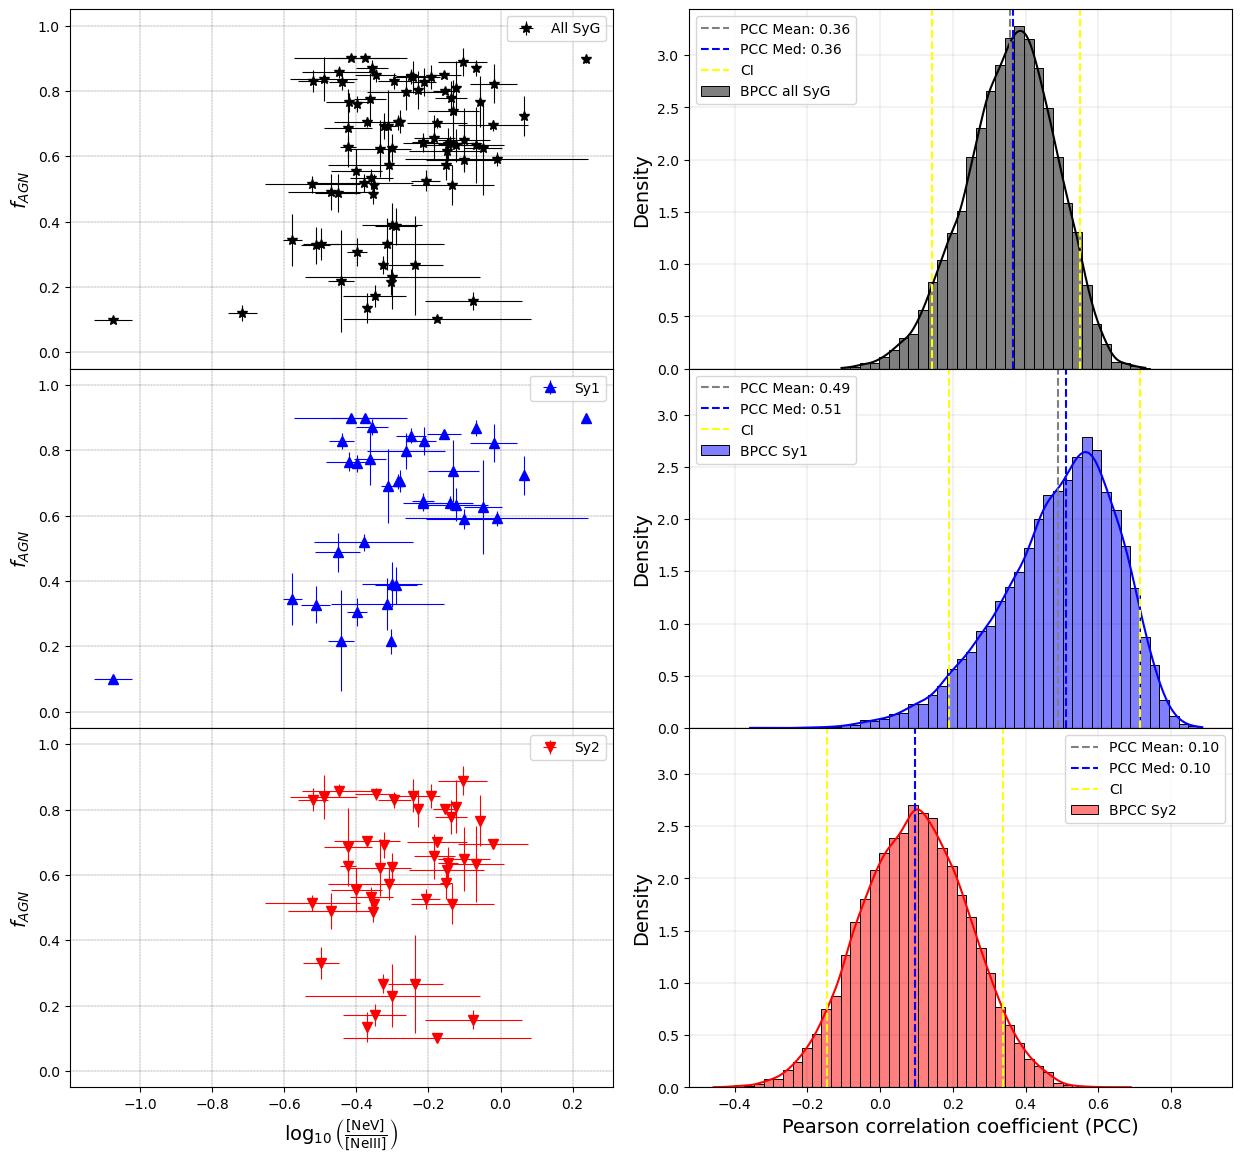

In [31]:
plt.figure(figsize=(15,14))
#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeIII]}$', fontsize=16)

ax1 = plt.subplot(321)
ax1.errorbar(NeVNeIII_Sy['log_[NeV]/[NeIII]'], NeVNeIII_Sy['bayes.agn.fracAGN'],NeVNeIII_Sy['bayes.agn.fracAGN_err'], NeVNeIII_Sy['log_[NeV]/[NeIII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All SyG')
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.2)

ax2 = plt.subplot(323,sharex=ax1,sharey=ax1)
ax2.errorbar(NeVNeIII_Sy1['log_[NeV]/[NeIII]'], NeVNeIII_Sy1['bayes.agn.fracAGN'],NeVNeIII_Sy1['bayes.agn.fracAGN_err'], NeVNeIII_Sy1['log_[NeV]/[NeIII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.set_ylabel(yl_label, fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.2)

ax3 = plt.subplot(325,sharex=ax1,sharey=ax1)
ax3.errorbar(NeVNeIII_Sy2['log_[NeV]/[NeIII]'], NeVNeIII_Sy2['bayes.agn.fracAGN'],NeVNeIII_Sy2['bayes.agn.fracAGN_err'], NeVNeIII_Sy2['log_[NeV]/[NeIII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeIII]}}\right)$', fontsize=fontsize_labels)
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.2)

bins = np.linspace(-0.4,0.9,50)

ax4 = plt.subplot(322)
sns.histplot(NeVNeIII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeVNeIII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeIII_fracAGN_Sy[1])
ax4.axvline(x=NeVNeIII_fracAGN_Sy[3],ls='--',color='blue',label='PCC Med: %.2f' %NeVNeIII_fracAGN_Sy[3])
ax4.axvline(x=NeVNeIII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeVNeIII_fracAGN_Sy[5],ls='--',color='yellow')
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(324,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeIII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC Sy1')
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeIII_fracAGN_Sy1[1])
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[3],ls='--',color='blue',label='PCC Med: %.2f' %NeVNeIII_fracAGN_Sy1[3])
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_ylabel(yr_label,fontsize=fontsize_labels)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(326,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeIII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC Sy2')
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeIII_fracAGN_Sy2[1])
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[3],ls='--',color='blue',label='PCC Med: %.2f' %NeVNeIII_fracAGN_Sy2[3])
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[5],ls='--',color='yellow')
ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set_ylabel(yr_label,fontsize=fontsize_labels)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.0,wspace=0.14) #Space between subplots
plt.savefig(path_graphs+'NeV_NeIII_vs_fracAGN_Sy1_vs_Sy2.jpg')

## [NeV]/[NeIII] vs other variables (outputs from CIGALE)

In [32]:
NeVNeIII_corr_SFR_Sy = df_NeVNeIII_Sy['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy['log_bayes.sfh.sfr'])
NeVNeIII_corr_SFR_Sy1 = df_NeVNeIII_Sy1['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy1['log_bayes.sfh.sfr'])
NeVNeIII_corr_SFR_Sy2 = df_NeVNeIII_Sy2['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy2['log_bayes.sfh.sfr'])

NeVNeIII_corr_m_star_Sy = df_NeVNeIII_Sy['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy['log_bayes.stellar.m_star'])
NeVNeIII_corr_m_star_Sy1 = df_NeVNeIII_Sy1['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy1['log_bayes.stellar.m_star'])
NeVNeIII_corr_m_star_Sy2 = df_NeVNeIII_Sy2['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy2['log_bayes.stellar.m_star'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeIII] ratio and Star Forming Rate:')
print('Total Sample: ',NeVNeIII_corr_SFR_Sy)
print('Seyfert 1: ',NeVNeIII_corr_SFR_Sy1)
print('Seyfert 2: ',NeVNeIII_corr_SFR_Sy2)

print('\nPearson\'s correlation coefficient between [NeV]/[NeIII] ratio and Star Mass:')
print('Total Sample: ',NeVNeIII_corr_m_star_Sy)
print('Seyfert 1: ',NeVNeIII_corr_m_star_Sy1)
print('Seyfert 2: ',NeVNeIII_corr_m_star_Sy2)


Pearson's correlation coefficient between [NeV]/[NeIII] ratio and Star Forming Rate:
Total Sample:  0.09950916821600395
Seyfert 1:  0.1073823746325168
Seyfert 2:  0.195065676088102

Pearson's correlation coefficient between [NeV]/[NeIII] ratio and Star Mass:
Total Sample:  0.15783766150637143
Seyfert 1:  0.16197483514172045
Seyfert 2:  0.17384789034592132


----------------------------------

# [NeIII]/[NeII]

In [33]:
print('From the', len(NeIIINeII_Sy),'galaxies with [NeIII]/[NeII] info:')
print(len(NeIIINeII_Sy1),'galaxies are Seyfert 1,')
print(len(NeIIINeII_Sy2),'galaxies are Seyfert 2,')
print(len(NeIIINeII_SyG),'galaxies are Seyfert without classification.')

From the 85 galaxies with [NeIII]/[NeII] info:
41 galaxies are Seyfert 1,
43 galaxies are Seyfert 2,
1 galaxies are Seyfert without classification.


## [NeIII]/[NeII] vs AGN Fraction

### Correlation Coefficients:

In [34]:
NeIIINeII_corr_fracAGN_Sy = df_NeIIINeII_Sy['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy['bayes.agn.fracAGN'])
NeIIINeII_corr_fracAGN_Sy1 = df_NeIIINeII_Sy1['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy1['bayes.agn.fracAGN'])
NeIIINeII_corr_fracAGN_Sy2 = df_NeIIINeII_Sy2['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeIII]/[NeII] ratio and AGN fraction:')
print('Total Sample: ',NeIIINeII_corr_fracAGN_Sy)
print('Seyfert 1: ',NeIIINeII_corr_fracAGN_Sy1)
print('Seyfert 2: ',NeIIINeII_corr_fracAGN_Sy2)

Pearson's correlation coefficient between [NeIII]/[NeII] ratio and AGN fraction:
Total Sample:  0.4900977451104232
Seyfert 1:  0.5198067248091811
Seyfert 2:  0.3709379771264009


In [35]:
NeIIINeII_fracAGN_Sy = bsc.bootstrapCorr(10000,0.8,df_NeIIINeII_Sy,'log_[NeIII]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeIIINeII_fracAGN_Sy[0]),'max:',max(NeIIINeII_fracAGN_Sy[0]))

Bootstraps results for the correlation coefficient between log_[NeIII]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 68 of 85
Number of samples: 10000
Median: 0.4927332568284448
Mean: 0.48743398628507145
Variance: 0.008634760215811173
Standard Desviation: 0.09292341048310256
90 % confidence interval: 0.3248472194905288 - 0.6308471445646455
min: -0.08199620983668483 max: 0.756288318480534


In [36]:
NeIIINeII_fracAGN_Sy1 = bsc.bootstrapCorr(10000,0.8,df_NeIIINeII_Sy1,'log_[NeIII]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeIIINeII_fracAGN_Sy1[0]),'max:',max(NeIIINeII_fracAGN_Sy1[0]))

Bootstraps results for the correlation coefficient between log_[NeIII]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 33 of 41
Number of samples: 10000
Median: 0.5296771124270047
Mean: 0.5151043440145813
Variance: 0.015550500102727466
Standard Desviation: 0.12470164434652602
90 % confidence interval: 0.28610480030536845 - 0.6939541331742041
min: -0.0664248899626499 max: 0.8708027098652783


In [37]:
NeIIINeII_fracAGN_Sy2 = bsc.bootstrapCorr(10000,0.8,df_NeIIINeII_Sy2,'log_[NeIII]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeIIINeII_fracAGN_Sy2[0]),'max:',max(NeIIINeII_fracAGN_Sy2[0]))

Bootstraps results for the correlation coefficient between log_[NeIII]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 34 of 43
Number of samples: 10000
Median: 0.375585252842059
Mean: 0.36815290320986244
Variance: 0.021657031057131435
Standard Desviation: 0.14716328026084305
90 % confidence interval: 0.11486430704272514 - 0.5907122167355287
min: -0.33899709822949065 max: 0.8166801862476201


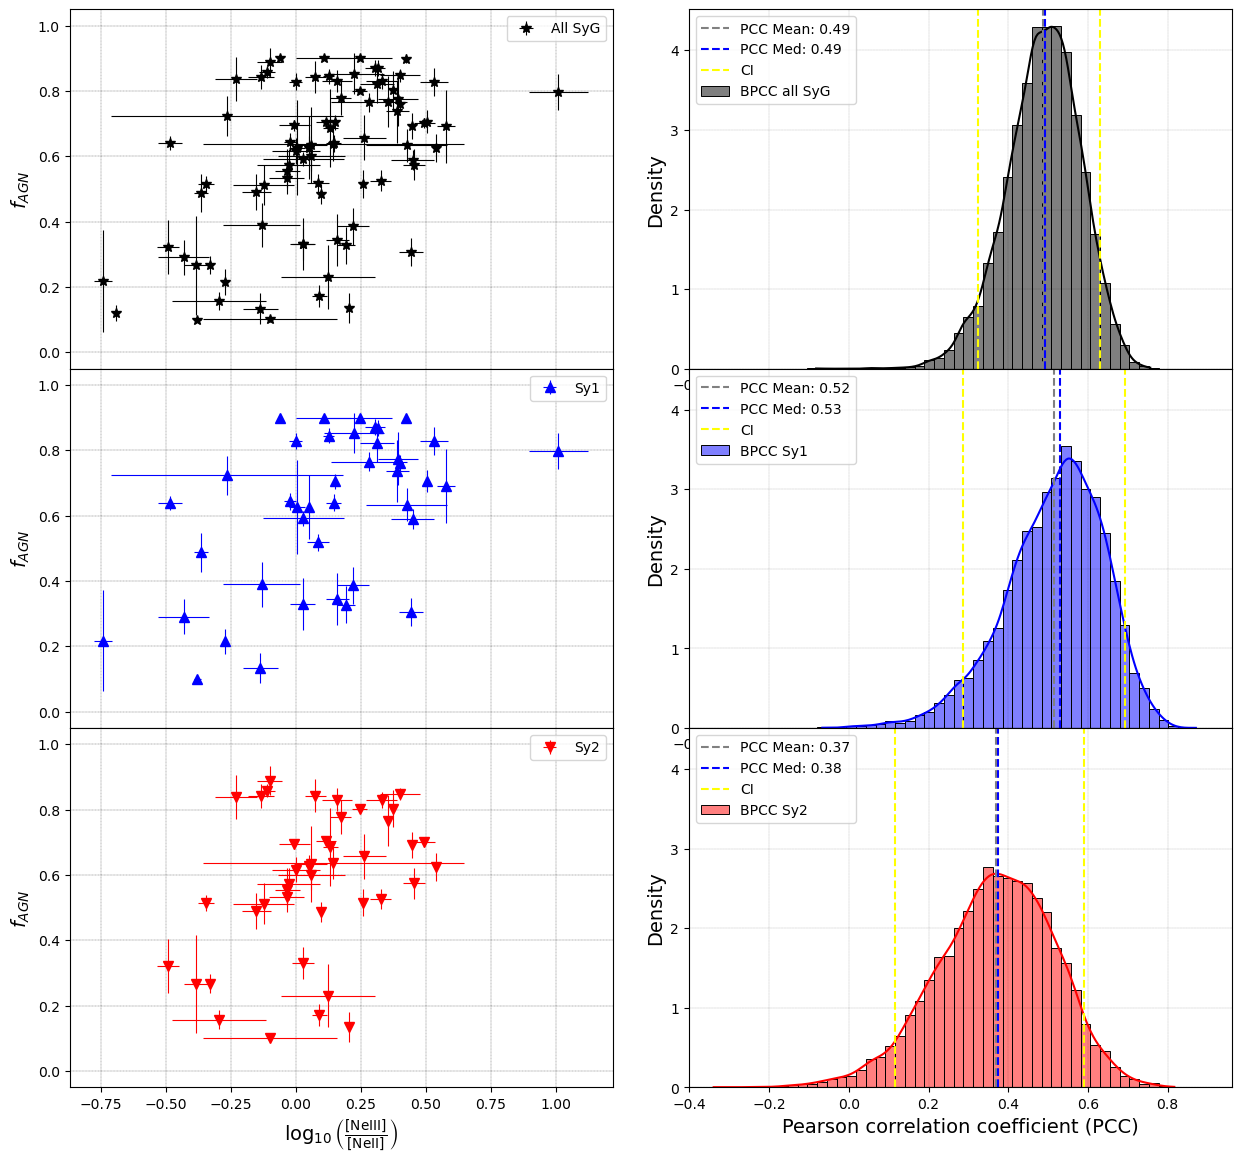

In [38]:
plt.figure(figsize=(15,14))

#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeIII]}{[NeII]}$', fontsize=16)

ax1 = plt.subplot(321)
ax1.errorbar(NeIIINeII_Sy['log_[NeIII]/[NeII]'], NeIIINeII_Sy['bayes.agn.fracAGN'],NeIIINeII_Sy['bayes.agn.fracAGN_err'], NeIIINeII_Sy['log_[NeIII]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All SyG')
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.2)

ax2 = plt.subplot(323,sharex=ax1,sharey=ax1)
ax2.errorbar(NeIIINeII_Sy1['log_[NeIII]/[NeII]'], NeIIINeII_Sy1['bayes.agn.fracAGN'],NeIIINeII_Sy1['bayes.agn.fracAGN_err'], NeIIINeII_Sy1['log_[NeIII]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.set_ylabel(yl_label, fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.2)

ax3 = plt.subplot(325,sharex=ax1,sharey=ax1)
ax3.errorbar(NeIIINeII_Sy2['log_[NeIII]/[NeII]'], NeIIINeII_Sy2['bayes.agn.fracAGN'],NeIIINeII_Sy2['bayes.agn.fracAGN_err'], NeIIINeII_Sy2['log_[NeIII]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeIII]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.2)

bins = np.linspace(-0.3,0.9,50)

ax4 = plt.subplot(322)
sns.histplot(NeIIINeII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeIIINeII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeIIINeII_fracAGN_Sy[1])
ax4.axvline(x=NeIIINeII_fracAGN_Sy[3],ls='--',color='blue',label='PCC Med: %.2f' %NeIIINeII_fracAGN_Sy[3])
ax4.axvline(x=NeIIINeII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeIIINeII_fracAGN_Sy[5],ls='--',color='yellow')
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(324,sharex=ax4,sharey=ax4)
sns.histplot(NeIIINeII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC Sy1')
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeIIINeII_fracAGN_Sy1[1])
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[3],ls='--',color='blue',label='PCC Med: %.2f' %NeIIINeII_fracAGN_Sy1[3])
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_ylabel(yr_label,fontsize=fontsize_labels)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(326,sharex=ax4,sharey=ax4)
sns.histplot(NeIIINeII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC Sy2')
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeIIINeII_fracAGN_Sy2[1])
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[3],ls='--',color='blue',label='PCC Med: %.2f' %NeIIINeII_fracAGN_Sy2[3])
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[5],ls='--',color='yellow')
ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set_ylabel(yr_label,fontsize=fontsize_labels)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.0,wspace=0.14) #Space between subplots
plt.savefig(path_graphs+'NeIII_NeII_vs_fracAGN_Sy1_vs_Sy2.jpg')

## [NeIII]/[NeII] vs other variables (outputs from CIGALE)

In [39]:
NeIIINeII_corr_SFR_Sy = df_NeIIINeII_Sy['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy['log_bayes.sfh.sfr'])
NeIIINeII_corr_SFR_Sy1 = df_NeIIINeII_Sy1['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy1['log_bayes.sfh.sfr'])
NeIIINeII_corr_SFR_Sy2 = df_NeIIINeII_Sy2['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy2['log_bayes.sfh.sfr'])

NeIIINeII_corr_m_star_Sy = df_NeIIINeII_Sy['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy['log_bayes.stellar.m_star'])
NeIIINeII_corr_m_star_Sy1 = df_NeIIINeII_Sy1['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy1['log_bayes.stellar.m_star'])
NeIIINeII_corr_m_star_Sy2 = df_NeIIINeII_Sy2['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy2['log_bayes.stellar.m_star'])

print('\nPearson\'s correlation coefficient between [NeIII]/[NeII] ratio and Star Forming Rate:')
print('Total Sample: ',NeIIINeII_corr_SFR_Sy)
print('Seyfert 1: ',NeIIINeII_corr_SFR_Sy1)
print('Seyfert 2: ',NeIIINeII_corr_SFR_Sy2)

print('\nPearson\'s correlation coefficient between [NeIII]/[NeII] ratio and Star Mass:')
print('Total Sample: ',NeIIINeII_corr_m_star_Sy)
print('Seyfert 1: ',NeIIINeII_corr_m_star_Sy1)
print('Seyfert 2: ',NeIIINeII_corr_m_star_Sy2)


Pearson's correlation coefficient between [NeIII]/[NeII] ratio and Star Forming Rate:
Total Sample:  -0.10366895580962038
Seyfert 1:  0.006738827463085218
Seyfert 2:  -0.25198047964786585

Pearson's correlation coefficient between [NeIII]/[NeII] ratio and Star Mass:
Total Sample:  0.0840728698619377
Seyfert 1:  0.2868485652702151
Seyfert 2:  -0.2677433109300889


--------------------------

# Galaxies according to their viewing angle (i from CIGALE)

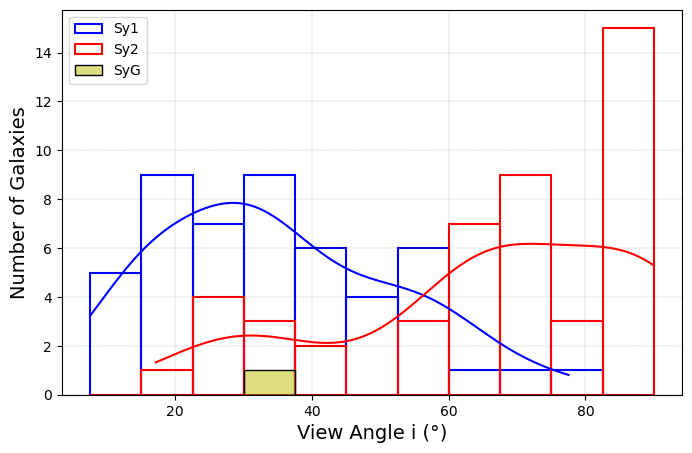

In [40]:
i_Sy1 = Ne_Sy1['bayes.agn.i']
i_Sy2 = Ne_Sy2['bayes.agn.i']
i_SyG = Ne_SyG['bayes.agn.i']
bins_Sy = np.linspace(min(Ne_Sy['bayes.agn.i']),max(Ne_Sy['bayes.agn.i']),12)#len(Ne_Sy)
#bins_Sy = freedman_diaconis(Ne_Sy['log_bayes.agn.disk_luminosity'])
plt.figure(figsize=(8,5))
sns.histplot(i_Sy1,kde=True,bins=bins_Sy,fill=False,label='Sy1',color='b')
sns.histplot(i_Sy2,kde=True,bins=bins_Sy,fill=False,label='Sy2',color='r')
sns.histplot(i_SyG,kde=True,bins=bins_Sy,fill=True,label='SyG',color='y')

plt.xlabel(r'View Angle i (°)',fontsize=14)
plt.ylabel(r'Number of Galaxies',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.legend()
plt.savefig(path_graphs+'hist_view_angle.jpg')

In [41]:
ks_2samp(i_Sy1,i_Sy2)

KstestResult(statistic=0.6843247937472862, pvalue=3.947576159656576e-11, statistic_location=59.34704859851327, statistic_sign=1)

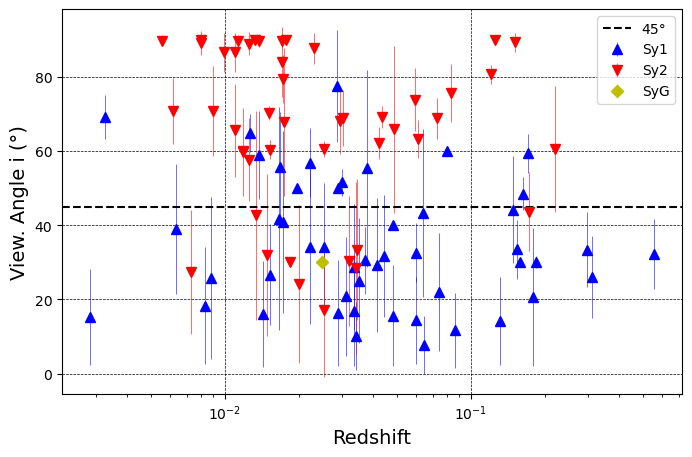

In [42]:
plt.figure(figsize=(8,5))
plt.errorbar(Ne_Sy1['redshift'],Ne_Sy1['bayes.agn.i'],Ne_Sy1['bayes.agn.i_err'],markersize=7,elinewidth=0.4,fmt='b^',label='Sy1')
plt.errorbar(Ne_Sy2['redshift'],Ne_Sy2['bayes.agn.i'],Ne_Sy2['bayes.agn.i_err'],markersize=7,elinewidth=0.4,fmt='rv',label='Sy2')
plt.errorbar(Ne_SyG['redshift'],Ne_SyG['bayes.agn.i'],Ne_SyG['bayes.agn.i_err'],markersize=6,elinewidth=0.4,fmt='yD',label='SyG')
plt.axhline(y=45,ls='--',color='black', label='45°')
plt.xlabel(r'Redshift',fontsize=14)
plt.xscale('log')
plt.ylabel(r'View. Angle i (°)',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.legend()
plt.savefig(path_graphs+'view_angle_vs_redshift.jpg')

### Classifying the galaxies by their viewing angle:

In [43]:
AGN_T1 = Ne_Sy[Ne_Sy['bayes.agn.i']<45]
AGN_T2 = Ne_Sy[Ne_Sy['bayes.agn.i']>45]

df_AGN_T1 = AGN_T1.to_pandas()
df_AGN_T2 = AGN_T2.to_pandas()

In [44]:
print('For the',len(AGN_T1),'galaxies with i<45°,',len(AGN_T1[AGN_T1['otype']=='Sy1']),'are Seyfert 1,',
      len(AGN_T1[AGN_T1['otype']=='Sy2']),'are Seyfert 2 and',len(AGN_T1[AGN_T1['otype']=='SyG']),
     'are Seyfert without classification')

print('For the',len(AGN_T2),'galaxies with i>45°,',len(AGN_T2[AGN_T2['otype']=='Sy2']),'are Seyfert 2,',
      len(AGN_T2[AGN_T2['otype']=='Sy1']),'are Seyfert 1 and',len(AGN_T2[AGN_T2['otype']=='SyG']),
     'are Seyfert without classification')

For the 47 galaxies with i<45°, 36 are Seyfert 1, 10 are Seyfert 2 and 1 are Seyfert without classification
For the 50 galaxies with i>45°, 37 are Seyfert 2, 13 are Seyfert 1 and 0 are Seyfert without classification


### [NeV]/[NeII] vs $f_{AGN}$ by their viewing angle

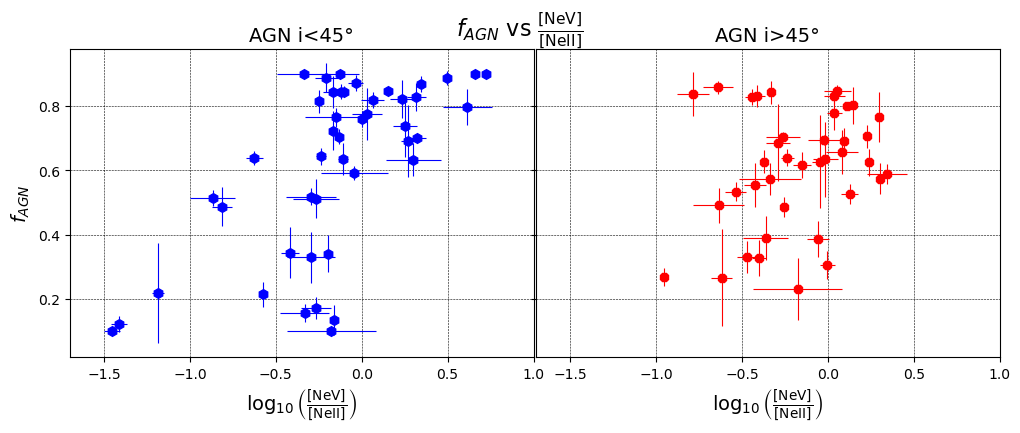

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4),sharey=True)
fig.suptitle(r'$f_{AGN}$ vs $\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}$', fontsize=16)

ax1.errorbar(AGN_T1['log_[NeV]/[NeII]'], AGN_T1['bayes.agn.fracAGN'],\
             AGN_T1['bayes.agn.fracAGN_err'], AGN_T1['log_[NeV]/[NeII]_err'],markersize=7,elinewidth=0.8,fmt='bh')
ax1.set_xlim(-1.7,1)
ax1.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax1.set_ylabel(r'$f_{AGN}$', fontsize=14)
ax1.set_title('AGN i<45°', fontsize=14)

ax2.errorbar(AGN_T2['log_[NeV]/[NeII]'], AGN_T2['bayes.agn.fracAGN'],\
             AGN_T2['bayes.agn.fracAGN_err'], AGN_T2['log_[NeV]/[NeII]_err'],markersize=7,elinewidth=0.8,fmt='r8')
ax2.set_xlim(-1.7,1)
ax2.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax2.set_title('AGN i>45°', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.4)
ax2.grid(color='k', linestyle='--', linewidth=0.4)
plt.subplots_adjust(wspace=0.005) #Space between subplots

In [46]:
NeVNeII_corr_AGNT1 = df_AGN_T1['log_[NeV]/[NeII]'].corr(df_AGN_T1['bayes.agn.fracAGN'])
NeVNeII_corr_AGNT2 = df_AGN_T2['log_[NeV]/[NeII]'].corr(df_AGN_T2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:')
print('AGN i<45°: ',NeVNeII_corr_AGNT1)
print('AGN i>45°: ',NeVNeII_corr_AGNT2)

Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:
AGN i<45°:  0.6573095657712715
AGN i>45°:  0.2594778983256281


Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 38 of 47
Number of samples: 10000
Median: 0.6581061565574211
Mean: 0.652317837966626
Variance: 0.007678956830522324
Standard Desviation: 0.08762965725439262
90 % confidence interval: 0.5013572911252184 - 0.7866590601573492


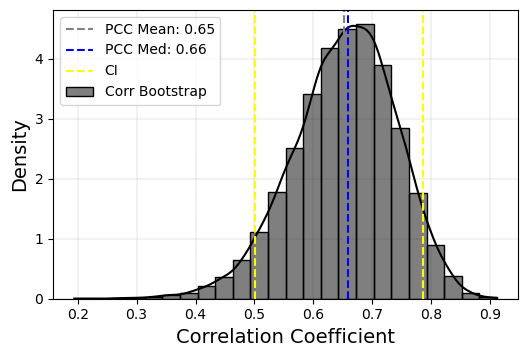

In [47]:
NeVNeII_fracAGN_AGNT1 = bsc.bootstrapCorr(10000,0.8,df_AGN_T1,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 40 of 50
Number of samples: 10000
Median: 0.2557767947603753
Mean: 0.24886118047853598
Variance: 0.0373989611051621
Standard Desviation: 0.19338811004082465
90 % confidence interval: -0.0847662160221839 - 0.5529907071432371


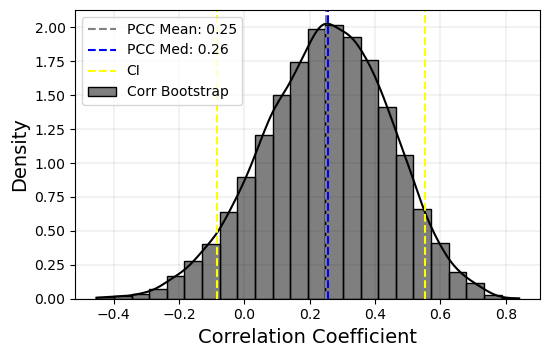

In [48]:
NeVNeII_fracAGN_AGNT2 = bsc.bootstrapCorr(10000,0.8,df_AGN_T2,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

---------------------
# Galaxies according to their AGN disc luminosity $\left(L^{disc}_{AGN} \right)$


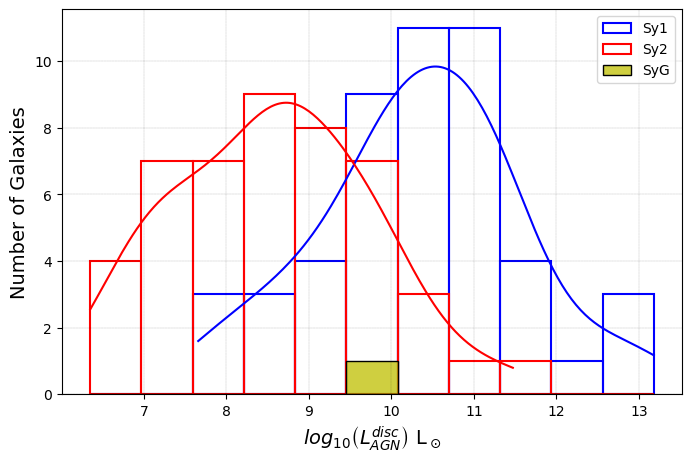

In [49]:
L_Sy1 = Ne_Sy1['log_bayes.agn.disk_luminosity']
L_Sy2 = Ne_Sy2['log_bayes.agn.disk_luminosity']
L_SyG = Ne_SyG['log_bayes.agn.disk_luminosity']
bins_Sy = np.linspace(min(Ne_Sy['log_bayes.agn.disk_luminosity']),max(Ne_Sy['log_bayes.agn.disk_luminosity']),12)#len(Ne_Sy)
#bins_Sy = freedman_diaconis(Ne_Sy['log_bayes.agn.disk_luminosity'])
plt.figure(figsize=(8,5))
sns.histplot(L_Sy1,kde=True,bins=bins_Sy,fill=False,label='Sy1',color='b')
sns.histplot(L_Sy2,kde=True,bins=bins_Sy,fill=False,label='Sy2',color='r')
sns.histplot(L_SyG,kde=False,bins=bins_Sy,fill=True,label='SyG',color='y')
plt.xlabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
plt.ylabel(r'Number of Galaxies',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.legend()
plt.savefig(path_graphs+'hist_AGN_disc_Lum_Sy.jpg')

In [50]:
ks_2samp(L_Sy1,L_Sy2)

KstestResult(statistic=0.60790273556231, pvalue=5.594847400398621e-09, statistic_location=9.782466461891259, statistic_sign=-1)

### $L^{disc}_{AGN}$ vs Redshift

Ramos et al. (2021) define a separation limit with the median values of the separation between Seyfert type as linear relation:

\begin{equation}
    \log \left(L^{disc}_{AGN} \right) = (9.20 \pm 0.08) + (8.67 \pm 0.61) \times \log(1+z)
\end{equation}

In [51]:
z = np.linspace(min(Ne_Sy['redshift']),max(Ne_Sy['redshift']),len(Ne_Sy))
L = 9.20 + 8.67*np.log10(1+z)
L_u = (9.20-0.08) + (8.67-0.61)*np.log10(1+z)
L_o = (9.20+0.08) + (8.67+0.61)*np.log10(1+z)
len(L)

97

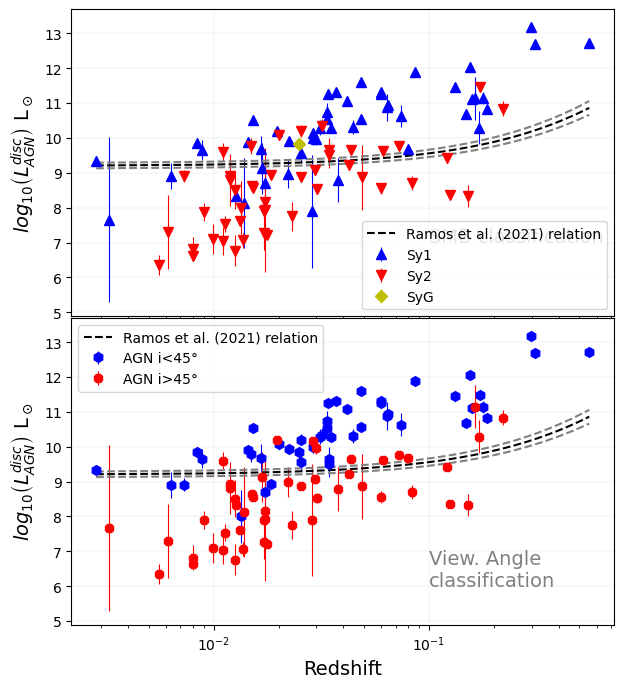

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,8),sharex=True)

ax1.set_xscale('log')
ax1.errorbar(Ne_Sy1['redshift'],Ne_Sy1['log_bayes.agn.disk_luminosity'],
             Ne_Sy1['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='b^',label='Sy1')
ax1.errorbar(Ne_Sy2['redshift'],Ne_Sy2['log_bayes.agn.disk_luminosity'],
             Ne_Sy2['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='rv',label='Sy2')
ax1.errorbar(Ne_SyG['redshift'],Ne_SyG['log_bayes.agn.disk_luminosity'],
             Ne_SyG['log_bayes.agn.disk_luminosity_err'],markersize=6,
             elinewidth=0.8,fmt='yD',label='SyG')
ax1.plot(z,L,ls='--',color='black',label='Ramos et al. (2021) relation')
ax1.plot(z,L_u,ls='--',color='gray')
ax1.plot(z,L_o,ls='--',color='gray')
#ax1.set_xlabel(r'Redshift',fontsize=14)
ax1.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
ax1.text(1e-1,7,'SMB classification',fontsize=14,color='gray')
#ax1.set_title('Sy1 and Sy2 SMB classification', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()

ax2.set_xscale('log')
ax2.errorbar(AGN_T1['redshift'],AGN_T1['log_bayes.agn.disk_luminosity'],
             AGN_T1['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='bh',label='AGN i<45°')
ax2.errorbar(AGN_T2['redshift'],AGN_T2['log_bayes.agn.disk_luminosity'],
             AGN_T2['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='r8',label='AGN i>45°')
ax2.plot(z,L,ls='--',color='black',label='Ramos et al. (2021) relation')
ax2.plot(z,L_u,ls='--',color='gray')
ax2.plot(z,L_o,ls='--',color='gray')
ax2.set_xlabel(r'Redshift',fontsize=14)
ax2.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
ax2.text(1e-1,6,'View. Angle \nclassification',fontsize=14,color='gray')
#ax2.set_title('View. Angle classification', fontsize=14)
ax2.grid(color='k', linestyle='--', linewidth=0.05)
ax2.legend()

plt.subplots_adjust(hspace=0.005) #Space between subplots
plt.savefig(path_graphs+'AGN_disc_L_vs_reshift.jpg')

### Classifying the galaxies by their AGN disc luminosity:

In [53]:
AGN_T1_L = Ne_Sy[Ne_Sy['log_bayes.agn.disk_luminosity'] > 9.20 + 8.67*np.log10(1+Ne_Sy['redshift'])]
AGN_T2_L = Ne_Sy[Ne_Sy['log_bayes.agn.disk_luminosity'] < 9.20 + 8.67*np.log10(1+Ne_Sy['redshift'])]

df_AGN_T1_L = AGN_T1_L.to_pandas()
df_AGN_T2_L = AGN_T2_L.to_pandas()

In [54]:
print('For the',len(AGN_T1_L),'galaxies with their AGN disc luminosity > than the Ramos et al. (2021) luminosity \
relation,',len(AGN_T1_L[AGN_T1_L['otype']=='Sy1']),'\nare Seyfert1 and',len(AGN_T1[AGN_T1['otype']=='Sy2']),\
      'are Seyfert2')

print('For the',len(AGN_T2_L),'galaxies with their AGN disc luminosity < than the Ramos et. al (2021) lumionosity \
relation,',len(AGN_T2_L[AGN_T2_L['otype']=='Sy2']),'\nare Seyfert2 and',len(AGN_T2_L[AGN_T2_L['otype']=='Sy1']),\
      'are Seyfert1')

For the 53 galaxies with their AGN disc luminosity > than the Ramos et al. (2021) luminosity relation, 40 
are Seyfert1 and 10 are Seyfert2
For the 44 galaxies with their AGN disc luminosity < than the Ramos et. al (2021) lumionosity relation, 35 
are Seyfert2 and 9 are Seyfert1


Just to check if we did the classification correctly, we will graph again the $L^{disc}_{AGN}$ vs Redshift:

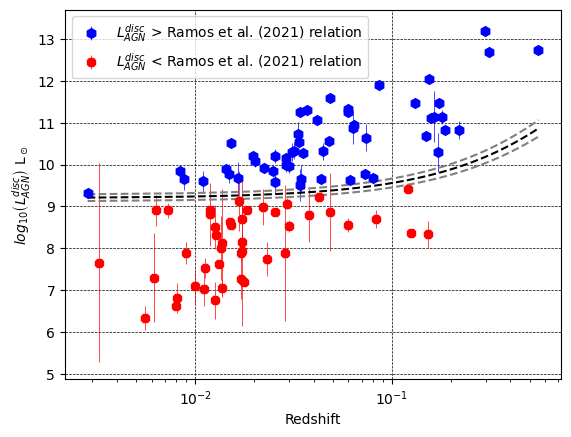

In [55]:
plt.figure()

plt.errorbar(AGN_T1_L['redshift'],AGN_T1_L['log_bayes.agn.disk_luminosity'],AGN_T1_L['log_bayes.agn.disk_luminosity_err'],
             markersize=7,elinewidth=0.5,fmt='bh',label=r'$L^{disc}_{AGN}$ > Ramos et al. (2021) relation')
plt.errorbar(AGN_T2_L['redshift'],AGN_T2_L['log_bayes.agn.disk_luminosity'],AGN_T2_L['log_bayes.agn.disk_luminosity_err'],
             markersize=7,elinewidth=0.5,fmt='r8',label=r'$L^{disc}_{AGN}$ < Ramos et al. (2021) relation')

plt.plot(z,L,ls='--',color='black')
plt.plot(z,L_u,ls='--',color='gray')
plt.plot(z,L_o,ls='--',color='gray')

plt.xlabel(r'Redshift')
plt.xscale('log')
plt.ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$')
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.legend()

### [NeV]/[NeII] vs $f_{AGN}$ by their AGN disc luminosity:

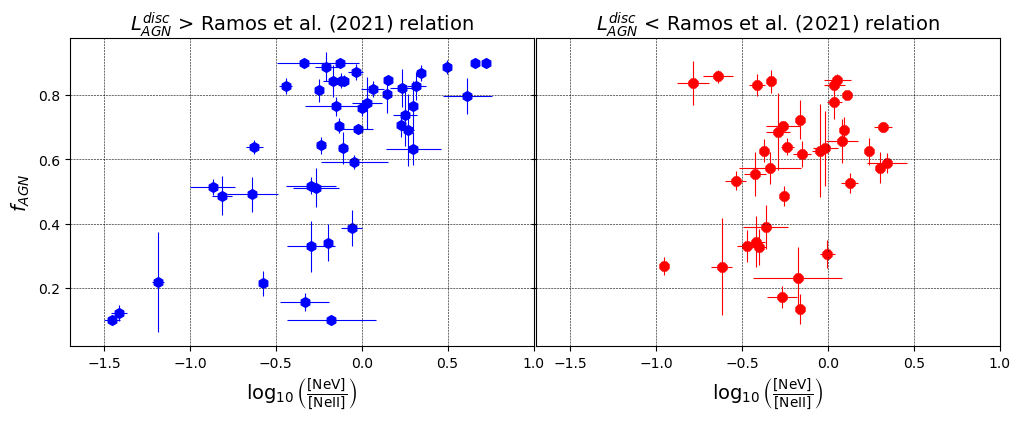

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4),sharey=True)
#fig.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)
ax1.scatter(AGN_T1_L['log_[NeV]/[NeII]'],AGN_T1_L['bayes.agn.fracAGN'],50,color='blue',marker = 'h')
ax1.errorbar(AGN_T1_L['log_[NeV]/[NeII]'], AGN_T1_L['bayes.agn.fracAGN'],\
             AGN_T1_L['bayes.agn.fracAGN_err'], AGN_T1_L['log_[NeV]/[NeII]_err'],elinewidth=0.8,fmt='b.')
ax1.set_xlim(-1.7,1)
ax1.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax1.set_ylabel(r'$f_{AGN}$', fontsize=14)
ax1.set_title(r'$L^{disc}_{AGN}$ > Ramos et al. (2021) relation', fontsize=14)
ax2.scatter(AGN_T2_L['log_[NeV]/[NeII]'], AGN_T2_L['bayes.agn.fracAGN'],50, color='red', marker = '8')
ax2.errorbar(AGN_T2_L['log_[NeV]/[NeII]'], AGN_T2_L['bayes.agn.fracAGN'],\
             AGN_T2_L['bayes.agn.fracAGN_err'], AGN_T2_L['log_[NeV]/[NeII]_err'],elinewidth=0.8,fmt='r.')
ax2.set_xlim(-1.7,1)
ax2.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax2.set_title(r'$L^{disc}_{AGN}$ < Ramos et al. (2021) relation', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.4)
ax2.grid(color='k', linestyle='--', linewidth=0.4)
plt.subplots_adjust(wspace=0.005) #Space between subplots

In [57]:
NeVNeII_corr_AGNT1_L = df_AGN_T1_L['log_[NeV]/[NeII]'].corr(df_AGN_T1_L['bayes.agn.fracAGN'])
NeVNeII_corr_AGNT2_L = df_AGN_T2_L['log_[NeV]/[NeII]'].corr(df_AGN_T2_L['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:')
print('AGN disc luminosty > Ramos et al. 2021 adjusment: ',NeVNeII_corr_AGNT1_L)
print('AGN disc luminosty < Ramos et al. 2021 adjusment: ',NeVNeII_corr_AGNT2_L)

Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:
AGN disc luminosty > Ramos et al. 2021 adjusment:  0.6781939979284888
AGN disc luminosty < Ramos et al. 2021 adjusment:  0.23410937130129808


Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 42 of 53
Number of samples: 10000
Median: 0.6810602852555538
Mean: 0.6701657870815344
Variance: 0.009629877953490002
Standard Desviation: 0.09813194155569328
90 % confidence interval: 0.4920760194987556 - 0.8114533213659967


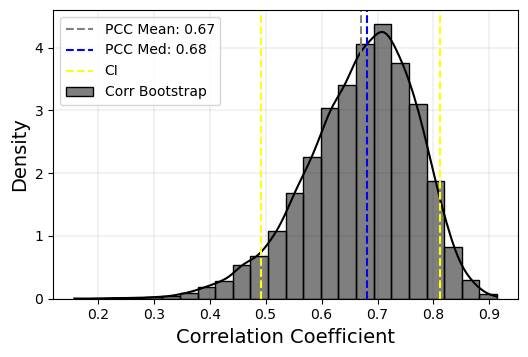

In [58]:
NeVNeII_fracAGN_AGNT1_L = bsc.bootstrapCorr(10000,0.8,df_AGN_T1_L,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 35 of 44
Number of samples: 10000
Median: 0.23816849053037797
Mean: 0.23392443822329237
Variance: 0.033428195250906
Standard Desviation: 0.1828337913267293
90 % confidence interval: -0.07401365979037575 - 0.5247333713269778


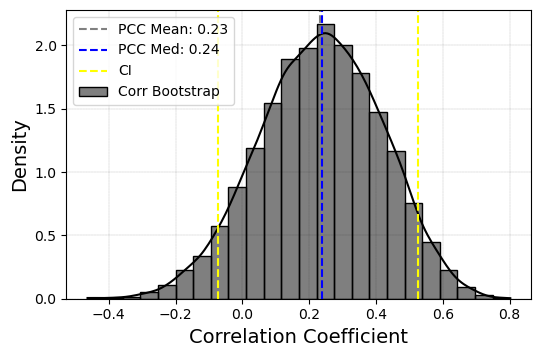

In [59]:
NeVNeII_fracAGN_AGNT2_L = bsc.bootstrapCorr(10000,0.8,df_AGN_T2_L,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

--------------------------

## $L^{disc}_{AGN}$ vs $i$

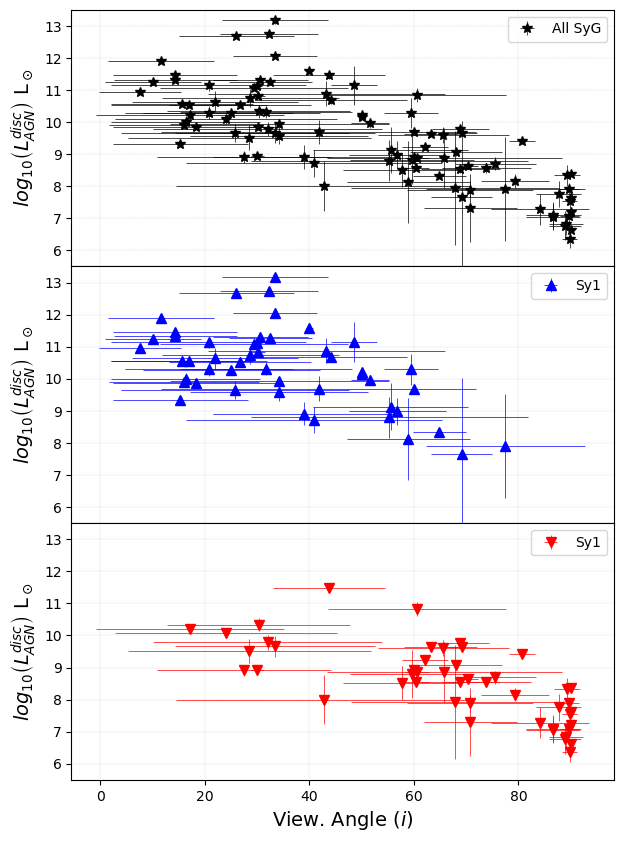

In [60]:
fig, (ax1, ax2, ax3,) = plt.subplots(3,1,figsize=(7,10),sharex=True)
#fig.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)

ax1.errorbar(Ne_Sy['bayes.agn.i'], Ne_Sy['log_bayes.agn.disk_luminosity'],Ne_Sy['log_bayes.agn.disk_luminosity_err'], Ne_Sy['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='k*',label='All SyG')
ax1.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax1.set_ylim(5.5,13.5)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()

ax2.errorbar(Ne_Sy1['bayes.agn.i'], Ne_Sy1['log_bayes.agn.disk_luminosity'],Ne_Sy1['log_bayes.agn.disk_luminosity_err'], Ne_Sy1['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='b^',label='Sy1')
ax2.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax2.set_ylim(5.5,13.5)
ax2.grid(color='k', linestyle='--', linewidth=0.05)
ax2.legend()

ax3.errorbar(Ne_Sy2['bayes.agn.i'], Ne_Sy2['log_bayes.agn.disk_luminosity'],Ne_Sy2['log_bayes.agn.disk_luminosity_err'], Ne_Sy2['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='rv',label='Sy1')
ax3.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax3.set_xlabel(r'View. Angle ($i$)', fontsize=14)
ax3.set_ylim(5.5,13.5)
ax3.grid(color='k', linestyle='--', linewidth=0.05)
ax3.legend()

plt.subplots_adjust(hspace=0.001) #Space between subplots

In [ ]:
LAGNdisc_i_Sy = bsc.bootstrapCorr(10000,0.8,df_Ne_Sy,'bayes.agn.i','log_bayes.agn.disk_luminosity',kdehisto=True)

---------------------------
## Alternative graphic for [NeV/NeII] vs AGN Frac:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(17,6),sharey=True)
#fig.suptitle(r'$\frac{[NeV]}{[NeII]}$ vs $f_{AGN}$', fontsize=16)
ax1.scatter(NeVNeII_Sy1['bayes.agn.fracAGN'],NeVNeII_Sy1['log_[NeV]/[NeII]'],50,color='blue',marker = '^')
ax1.errorbar(NeVNeII_Sy1['bayes.agn.fracAGN'], NeVNeII_Sy1['log_[NeV]/[NeII]'],\
             NeVNeII_Sy1['log_[NeV]/[NeII]_err'], NeVNeII_Sy1['bayes.agn.fracAGN_err'],elinewidth=0.8,fmt='b.')
ax1.set_xlabel(r'$f_{AGN}$', fontsize=14)
ax1.set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax1.set_title('Seyfert 1', fontsize=14)
ax2.scatter(NeVNeII_Sy2['bayes.agn.fracAGN'], NeVNeII_Sy2['log_[NeV]/[NeII]'],50, color='red', marker = 'v')
ax2.errorbar(NeVNeII_Sy2['bayes.agn.fracAGN'], NeVNeII_Sy2['log_[NeV]/[NeII]'], \
             NeVNeII_Sy2['log_[NeV]/[NeII]_err'], NeVNeII_Sy2['bayes.agn.fracAGN_err'],elinewidth=0.8,fmt='r.')
ax2.set_xlabel(r'$f_{AGN}$', fontsize=14)
ax2.set_title('Seyfert 2', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.4)
ax2.grid(color='k', linestyle='--', linewidth=0.4)
plt.subplots_adjust(wspace=0.01) #Space between subplots

-------------------------------------
## Notebook Info

In [ ]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

-----------------------------------------
### Cells for test

In [ ]:
from scipy.stats import gamma

corrdata = []
for i in range(10000):
    sample = df_NeVNeII_Sy2.sample(frac=0.8,replace=True, random_state=i)
    corr = np.log10(sample['redshift']).corr(sample['log_bayes.agn.disk_luminosity'])
    corrdata.append(corr)

mu, std = norm.fit(corrdata)
shape, loc, scale = gamma.fit(corrdata)

bins = np.linspace(min(corrdata), max(corrdata),40)
plt.hist(corrdata, bins=bins, density=True, histtype='step')
plt.axvline(x=np.mean(corrdata),ls='--',color='gray')
plt.axvline(x=np.percentile(corrdata,5),ls='--',color='gray')
plt.axvline(x=np.percentile(corrdata,95),ls='--',color='gray')
plt.xlabel(r'Correlation Coefficient')
plt.ylabel('Density')
plt.grid(color='k', linestyle='--', linewidth=0.1)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 10000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=0.5)

# Graficar distribución gamma
plt.plot(x, gamma.pdf(x, shape, loc=loc, scale=scale))

p = sns.histplot(corrdata,kde=True,fill=False,stat=stat)

lines = p.get_lines()

for line in lines:
    x, y = line.get_data()
    #print(x[np.argmax(y)])
    #ax4.axvline(x[np.argmax(y)], ls='--', color='black')

print('\n',np.median(corrdata))
print(mu)
print(std)
print(np.percentile(corrdata,5),'-',np.percentile(corrdata,95))
print(shape, loc, scale)

-------------------------------

In [ ]:
NeVNeII_Sy1['log_[NeV]/[NeII]'].info('stats') 

In [ ]:
NeVNeII_Sy1['Main_id','redshift','[NeV]*','[NeII]*','[NeV]/[NeII]*','log_[NeV]/[NeII]'].show_in_notebook()

In [ ]:
NeVNeII_Sy2['Main_id','redshift','[NeV]*','[NeII]*','[NeV]/[NeII]*','log_[NeV]/[NeII]'].show_in_notebook()

In [ ]:
Ne_Sy.show_in_notebook()